# Equivalence of Non-Orthogonal Radiation Modes and Orthogonal ones.

We've observed that propagating with non-orthogonal radiation modes is possible by inverting the integral coefficient system to find A(Z) and B(Z).  We have seen also that not only do they give the same results in the limit, but that they give the exactly same results at each step, so that it seems inverting the system is intimately related to finding an orthogonal set of modes.  Here we explore this further.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy.linalg import eig
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real
from scipy.integrate import quad
from scipy.optimize import newton

%matplotlib widget

In [82]:
# A = SlabExact(ns=[1.44, 1.45, 1.44], ts=[2e-6, 2e-6, 2e-6], symmetric=True)

A = SlabExact(ns=[1.4, 1.5, 1.6, 1.4], ts=[2e-6, 2e-6, 2e-6, 2e-6], xrefs=[100,100,100,100],symmetric=True)

In [111]:
# def f0(x):
#     conds = [(x<-1), ((-1<=x)*(x<=1)), (x>1)]
#     funcs = [0, lambda x: 1-x**2, 0]
#     return np.piecewise(x, conds, funcs)

def f0(x):
    conds = [(x<-1), ((-1<=x)*(x<=1)), (x>1)]
    funcs = [0, lambda x: np.e**(-x) * (1-x)*(1-x**2), 0]
    return np.piecewise(x, conds, funcs)


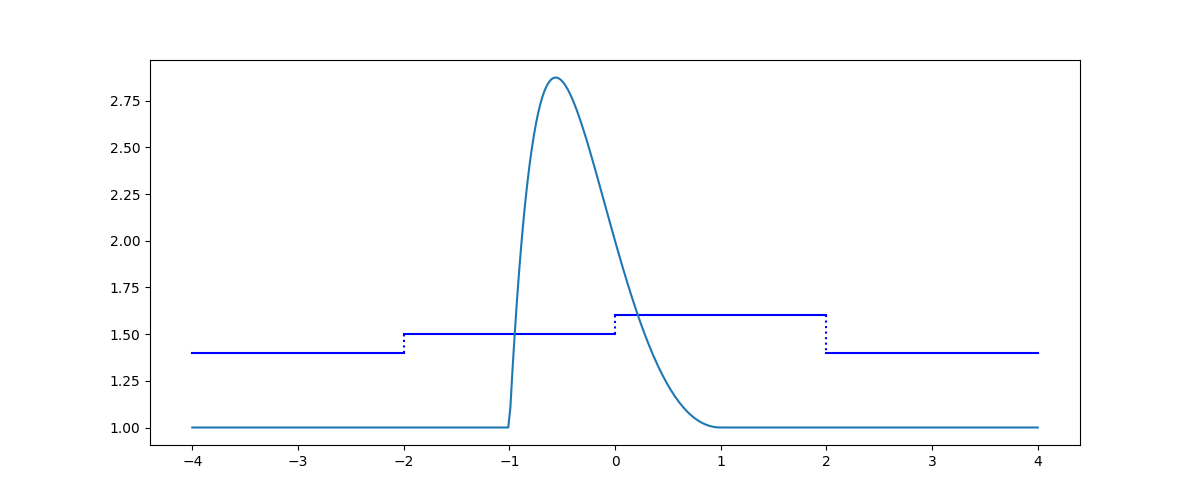

In [112]:
A.plot_refractive_index()
A.add_1d_plot(lambda x: f0(x) +1)

# Equality of approaches

Below we observe that using non-orthogonal and orthogonal mode sets gives exactly the same results at each value of Z

### Non-Orthogonal

In [113]:
S = np.array([[0, 1], [1, 0]])

xs = np.linspace(-5, 5, 800)
zs = np.linspace( 0, 8, 800)

Ys_no = np.zeros((len(zs), len(xs)), dtype=complex)
ys_no = np.zeros(len(xs), dtype=complex)

Zs = [2]

f_As_no = np.zeros_like(Zs,dtype=complex)
f_Bs_no = np.zeros_like(Zs,dtype=complex)
C_As_no = np.zeros_like(Zs,dtype=complex)
C_Bs_no = np.zeros_like(Zs,dtype=complex)


for i,Z in enumerate(Zs):
    
    Fa = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation')
    Fb = A.fields(Z, c0=1+2j, c1=1-2j, Z_plane=True, mode_type='radiation')
    Ca = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation').T
    Cb = A.coefficients(Z, c0=1+2j, c1=1-2j, Z_plane=True, mode_type='radiation').T

    # Fa = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation')
    # Fb = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation', sign='-1')
    # Ca = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation').T
    # Cb = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation', sign='-1').T
    
    Naa = Ca[0].T @ S @ Ca[0] + Ca[-1].T @ S @ Ca[-1]
    Nbb = Cb[0].T @ S @ Cb[0] + Cb[-1].T @ S @ Cb[-1]
    Nab = Ca[0].T @ S @ Cb[0] + Ca[-1].T @ S @ Cb[-1]
    detN = Naa * Nbb - Nab**2

    f_A = quad(lambda x: f0(x) * Fa(x), -1, 1,  complex_func=True)[0]
    f_B = quad(lambda x: f0(x) * Fb(x), -1, 1,  complex_func=True)[0]
    
    C_A = 1/(np.pi*detN) * (f_A * Nbb - f_B * Nab) 
    C_B = 1/(np.pi*detN) * (-f_A * Nab + f_B * Naa)
    
    f_As_no[i], f_Bs_no[i] = f_A, f_B
    C_As_no[i], C_Bs_no[i] = C_A, C_B

    Ys_no += C_A * Fa(xs, zs) + C_B * Fb(xs, zs)
    ys_no += C_A * Fa(xs) + C_B * Fb(xs)
    

# Orthogonal

In [114]:
S = np.array([[0, 1], [1, 0]])

xs = np.linspace(-5, 5, 800)
zs = np.linspace( 0, 8, 800)
Ys_o = np.zeros((len(zs), len(xs)), dtype=complex)
ys_o = np.zeros(len(xs), dtype=complex)

Zs = [2]

f_As_o = np.zeros_like(Zs,dtype=complex)
f_Bs_o = np.zeros_like(Zs,dtype=complex)
C_As_o = np.zeros_like(Zs,dtype=complex)
C_Bs_o = np.zeros_like(Zs,dtype=complex)

for i,Z in enumerate(Zs):
    
    Fa = A.fields(Z, Z_plane=True, mode_type='radiation')
    Fb = A.fields(Z, Z_plane=True, mode_type='radiation', sign='-1')
    
    Ca = A.coefficients(Z, Z_plane=True, mode_type='radiation').T
    Cb = A.coefficients(Z, Z_plane=True, mode_type='radiation', sign='-1').T
        
    Naa = Ca[0].T @ S @ Ca[0] + Ca[-1].T @ S @ Ca[-1]
    Nbb = Cb[0].T @ S @ Cb[0] + Cb[-1].T @ S @ Cb[-1]
    Nab = Ca[0].T @ S @ Cb[0] + Ca[-1].T @ S @ Cb[-1]
    
    detN = Naa * Nbb - Nab**2

    f_A = quad(lambda x: f0(x) * Fa(x), -1, 1,  complex_func=True)[0]
    f_B = quad(lambda x: f0(x) * Fb(x), -1, 1,  complex_func=True)[0]
    
    C_A = 1/(np.pi*detN) * (f_A * Nbb - f_B * Nab) 
    C_B = 1/(np.pi*detN) * (-f_A * Nab + f_B * Naa)
    
    f_As_o[i], f_Bs_o[i] = f_A, f_B
    C_As_o[i], C_Bs_o[i] = C_A, C_B

    # Ys_o += (C_A * Fa(xs, zs) + C_B * Fb(xs, zs))* 1
    # ys_o += (C_A * Fa(xs) + C_B * Fb(xs))* 1
    
    Ys_o += 1/2*(f_A * Fa(xs, zs)  + f_B * Fb(xs, zs))
    ys_o += 1/2*(f_A * Fa(xs) +  f_B * Fb(xs))


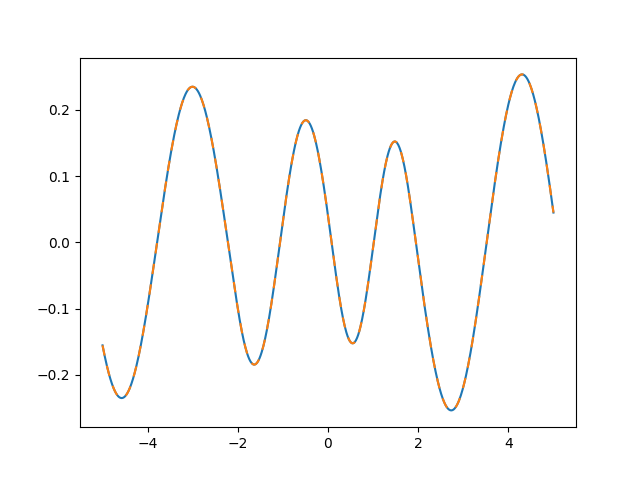

In [115]:
plt.close('all')
plt.plot(xs, ys_o.real)
plt.plot(xs, ys_no.real, linestyle=(0,(5,5)));


What does all this say?  It says that

$ x--$